In [10]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
# faster rcnn model이 포함된 library
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

In [2]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max)   boxes: x, y, w, h => x_min, y_min, x_max, y_max 로 변환
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
                                
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)
                                
        segmentation = np.array([x['segmentation'] for x in anns], dtype=object)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds}

        # transform
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [3]:
def get_train_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})   ## Bbox format, 등 정보가 필요하다


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [4]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


def collate_fn(batch):
    return tuple(zip(*batch))


In [5]:
def train_fn(num_epochs, train_data_loader, optimizer, model, device):
    best_loss = 1000
    loss_hist = Averager()
    for epoch in range(num_epochs):
        loss_hist.reset()

        for images, targets, image_ids in tqdm(train_data_loader):

            # gpu 계산을 위해 image.to(device)
            images = list(image.float().to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # calculate loss
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)

            # backward
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        print(f"Epoch #{epoch+1} loss: {loss_hist.value}")
        if loss_hist.value < best_loss:
            torch.save(model.state_dict(), f'faster_rcnn/faster_rcnn.pth')
            best_loss = loss_hist.value

In [6]:
## data 가져오기
annotation = '../input/data/train.json'
data_dir = '../input/data'
train_dataset = CustomDataset(annotation, data_dir, get_train_transform())

# data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


loading annotations into memory...
Done (t=7.56s)
creating index...
index created!


image shape: [3, 512, 512]


TypeError: list indices must be integers or slices, not str

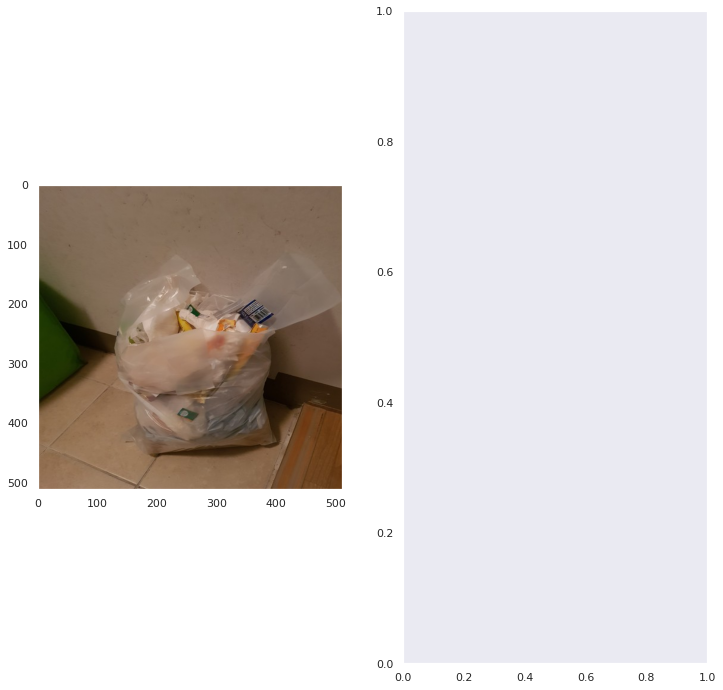

In [14]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, boxs, image_infos in train_data_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = boxs
    
    break
    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
# print('mask shape: ', list(temp_masks[0].shape))
# print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

# ax2.imshow(temp_masks[0])
# ax2.grid(False)
# ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [6]:
def main():
    annotation = '../input/data/train.json'
    data_dir = '../input/data'
    train_dataset = CustomDataset(annotation, data_dir, get_train_transform())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(device)
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = 11

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    num_epochs = 12

    train_fn(num_epochs, train_data_loader, optimizer, model, device)

In [7]:
if __name__ == '__main__':
    main()

loading annotations into memory...
Done (t=3.56s)
creating index...
index created!
cuda


  0%|          | 0/164 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)
100%|██████████| 164/164 [04:53<00:00,  1.79s/it]


Epoch #1 loss: 0.9235458329501676


FileNotFoundError: [Errno 2] No such file or directory: 'faster_rcnn/faster_rcnn.pth'